# annotate_GRCh38.py

In [43]:
#!/usr/bin/env python3
import re
from glob import glob
import pandas as pd
import seaborn as sns
import twobitreader
from vcf import Reader as vcf_reader
import os

In [44]:
REFERENCE_FILE = "/home/hcampos/common_bioinformatics/files/references/mm10.2bit"
INPUT_DIR_MVF = "/home/hcampos/common_bioinformatics/files/vcf_somsig/mvf/"
INPUT_DIR_SP = "/home/hcampos/common_bioinformatics/files/vcf_somsig/sp/"
INPUT_DIR_MC = "/home/hcampos/common_bioinformatics/files/vcf_somsig/mc/"

VALID_CHR = ["chr{}".format(x) for x in list(range(1, 23)) + ['X', 'Y']]
SIGNATURE_PATTERNS = {
    'WRCY': {'mutation': {'f': r'C-[TGA]', 'r': r'G-[ACT]'}, 'context': {'f': r'[AT][AG].[CT].', 'r': r'.[AG].[CT][AT]'}},
    'WA': {'mutation': {'f': r'A-[TGC]', 'r': r'T-[CGA]'}, 'context': {'f': r'.[AT].[ACGT].', 'r': r'.[ACGT].[AT].'}},
    'RCG': {'mutation': {'f': r'C-[TGA]', 'r': r'G-[ACT]'}, 'context': {'f': r'.[AG].G.', 'r': '.C.[TC].'}}
}

In [45]:
def get_signature_presence(df):
    df['SIG'] = "None"
    for p in SIGNATURE_PATTERNS.keys():
        for s in ['f', 'r']:
            df.loc[df['SUBSTITUTION'].str.match(SIGNATURE_PATTERNS[p]['mutation'][s]) & df['CONTEXT'].str.match(
                SIGNATURE_PATTERNS[p]['context'][s]), 'SIG'] = p
    return df

## Data Load

# Minimun Coverage

In [92]:
records = []  # records by chrom
for fn in sorted(glob(INPUT_DIR_MC + 'DT_uy_4_TU*.vcf')):
    experiment = re.sub(r'^.*/|\..*', '', fn)
    cov = int(fn.split('_')[-3][2:])
    #print (cov)
    with open(fn) as f:
        for r in vcf_reader(f):
            if r.CHROM in VALID_CHR:
                for s in r.samples:
                    if s.sample == 'TUMOR':
                        tumor_sample = s
                records.append([experiment, cov, r.CHROM, r.POS, "{}-{}".format(r.REF, r.ALT[0]), tumor_sample['FREQ']])

# convert data to dataframe
df = pd.DataFrame(records, columns=['EXPERIMENT', 'MIN_COV', 'CHROM', 'POS', 'SUBSTITUTION', 'VAF'])
reference = twobitreader.TwoBitFile(REFERENCE_FILE)

# get subsitution, context, sig
df['CONTEXT'] = df.apply(lambda x: reference[x.CHROM].get_slice(x.POS-3, x.POS+2).upper(), axis=1)
df['CONTEXT'] = df.CONTEXT.str[:2] + '.' + df.CONTEXT.str[3:]
df = get_signature_presence(df)
df['SUBSTITUTION'] = df['SUBSTITUTION'].str.replace('-', '>')

In [93]:
df_grouped = pd.DataFrame(df.groupby(["MIN_COV", "SIG"]).size()).rename(columns={0:'n'}).reset_index()

In [94]:
df_grouped = df_grouped.merge(df_grouped.groupby('MIN_COV').agg(sum).reset_index(), on = ['MIN_COV'])

In [95]:
df_grouped.columns = ['min_cov', 'sig', 'n', 'total']

In [96]:
df_tmp = df_grouped[df_grouped.sig != 'None'].groupby('min_cov').agg({'n': 'sum', 'total': 'first'}).reset_index()
df_tmp['sig'] = "All"

In [97]:
df_grouped = pd.concat([df_grouped, df_tmp], sort=True)
df_grouped = df_grouped.sort_values(['min_cov', 'sig'])

In [98]:
df_grouped['perc'] = df_grouped.n / df_grouped.total

In [99]:
df_grouped = df_grouped.reset_index(drop=True)

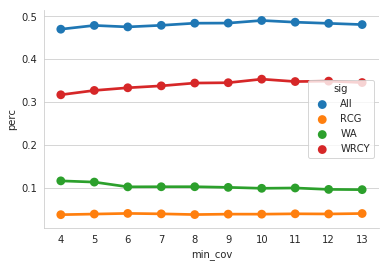

In [100]:
#savefig
i = 1
plot = sns.pointplot(data=df_grouped[df_grouped.sig != 'None'], x='min_cov', y='perc', hue='sig')
sns.despine()
sns.set_style("whitegrid")
fig = plot.get_figure()
while os.path.exists('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/mc/output', i)):
    i += 1
fig.savefig('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/mc/output', i))

# Min Var Freq

In [101]:
records = []  # records by chrom
for fn in sorted(glob(INPUT_DIR_MVF + 'DT_uy_4_TU*.vcf')):
    experiment = re.sub(r'^.*/|\..*', '', fn)
    mvf = float("0.{}".format(fn.split('_')[-2][4:]))
    #print (cov)
    with open(fn) as f:
        for r in vcf_reader(f):
            if r.CHROM in VALID_CHR:
                for s in r.samples:
                    if s.sample == 'TUMOR':
                        tumor_sample = s
                records.append([experiment, mvf, r.CHROM, r.POS, "{}-{}".format(r.REF, r.ALT[0]), tumor_sample['FREQ']])

# convert data to dataframe
df = pd.DataFrame(records, columns=['EXPERIMENT', 'MIN_VAR_FREQ', 'CHROM', 'POS', 'SUBSTITUTION', 'VAF'])
reference = twobitreader.TwoBitFile(REFERENCE_FILE)

# get substitution, context, sig
df['CONTEXT'] = df.apply(lambda x: reference[x.CHROM].get_slice(x.POS-3, x.POS+2).upper(), axis=1)
df['CONTEXT'] = df.CONTEXT.str[:2] + '.' + df.CONTEXT.str[3:]
df = get_signature_presence(df)
df['SUBSTITUTION'] = df['SUBSTITUTION'].str.replace('-', '>')

In [102]:
df_grouped = pd.DataFrame(df.groupby(["MIN_VAR_FREQ", "SIG"]).size()).rename(columns={0:'n'}).reset_index()

In [103]:
df_grouped = df_grouped.merge(df_grouped.groupby('MIN_VAR_FREQ').agg(sum).reset_index(), on = ['MIN_VAR_FREQ'])

In [104]:
df_grouped.columns = ['min_var_freq', 'sig', 'n', 'total']

In [105]:
df_tmp = df_grouped[df_grouped.sig != 'None'].groupby('min_var_freq').agg({'n': 'sum', 'total': 'first'}).reset_index()
df_tmp['sig'] = "All"

In [106]:
df_grouped = pd.concat([df_grouped, df_tmp], sort=True)
df_grouped = df_grouped.sort_values(['min_var_freq', 'sig'])

In [107]:
df_grouped['perc'] = df_grouped.n / df_grouped.total

In [108]:
df_grouped = df_grouped.reset_index(drop=True)

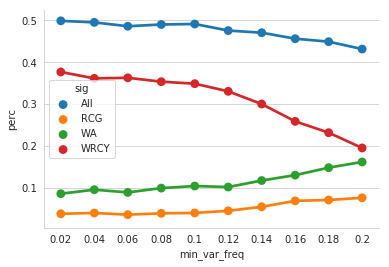

In [109]:
#savefig
i = 1
plot = sns.pointplot(data=df_grouped[df_grouped.sig != 'None'], x='min_var_freq', y='perc', hue='sig')
sns.despine()
fig = plot.get_figure()
while os.path.exists('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/mvf/output', i)):
    i += 1
fig.savefig('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/mvf/output', i))

# Somatic P

In [110]:
records = []  # records by chrom
for fn in sorted(glob(INPUT_DIR_SP + 'DT_uy_4_TU*.vcf')):
    experiment = re.sub(r'^.*/|\..*', '', fn)
    sp = float("0.{}".format(fn.split('.')[0].split('_')[-1][3:]))
    with open(fn) as f:
        for r in vcf_reader(f):
            if r.CHROM in VALID_CHR:
                for s in r.samples:
                    if s.sample == 'TUMOR':
                        tumor_sample = s
                records.append([experiment, sp, r.CHROM, r.POS, "{}-{}".format(r.REF, r.ALT[0]), tumor_sample['FREQ']])

# convert data to dataframe
df = pd.DataFrame(records, columns=['EXPERIMENT', 'SOMATIC_P', 'CHROM', 'POS', 'SUBSTITUTION', 'VAF'])
reference = twobitreader.TwoBitFile(REFERENCE_FILE)

# get subsitution, context, sig
df['CONTEXT'] = df.apply(lambda x: reference[x.CHROM].get_slice(x.POS-3, x.POS+2).upper(), axis=1)
df['CONTEXT'] = df.CONTEXT.str[:2] + '.' + df.CONTEXT.str[3:]
df = get_signature_presence(df)
df['SUBSTITUTION'] = df['SUBSTITUTION'].str.replace('-', '>')

In [111]:
df_grouped = pd.DataFrame(df.groupby(["SOMATIC_P", "SIG"]).size()).rename(columns={0:'n'}).reset_index()

In [112]:
df_grouped = df_grouped.merge(df_grouped.groupby('SOMATIC_P').agg(sum).reset_index(), on = ['SOMATIC_P'])

In [113]:
df_grouped.columns = ['somatic_p', 'sig', 'n', 'total']

In [114]:
df_tmp = df_grouped[df_grouped.sig != 'None'].groupby('somatic_p').agg({'n': 'sum', 'total': 'first'}).reset_index()
df_tmp['sig'] = "All"

In [115]:
df_grouped = pd.concat([df_grouped, df_tmp], sort=True)
df_grouped = df_grouped.sort_values(['somatic_p', 'sig'])

In [116]:
df_grouped['perc'] = df_grouped.n / df_grouped.total

In [117]:
df_grouped = df_grouped.reset_index(drop=True)

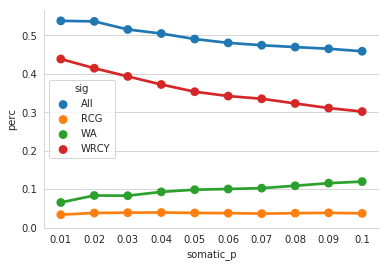

In [118]:
#savefigure
i = 1
plot = sns.pointplot(data=df_grouped[df_grouped.sig != 'None'], x='somatic_p', y='perc', hue='sig')
sns.despine()
fig = plot.get_figure()
while os.path.exists('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/sp/output', i)):
    i += 1
fig.savefig('{}{:d}.pdf'.format('/home/hcampos/thesis/memory/memory_used/figures/plot/motif_aid/sp/output', i))